# KNN - MULTICLASS CLASSIFICATION (finale)

In [93]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [94]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

In [95]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

### Delete outliers

In [96]:
copy_train = copy_train[copy_train["outlier_no_type"] != True]
copy_test = copy_test[copy_test["outlier_no_type"] != True]

### Mapping of the target variable

In [97]:
y = np.array(copy_train['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(copy_train['titleType'].unique())}

#aggiungo una nuova colonna
copy_train['titleType_encoded'] = copy_train['titleType'].map(y_map)
copy_test['titleType_encoded'] = copy_test['titleType'].map(y_map)

y_map  # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

### Feature preprocessing and deletion

In [98]:
copy_train["canHaveEpisodes"] = copy_train["canHaveEpisodes"].astype(int)
copy_test["canHaveEpisodes"] = copy_test["canHaveEpisodes"].astype(int)
copy_train = copy_train.drop(["originalTitle", "runtimeMinutes", "endYear", "titleType"], axis=1)
copy_test = copy_test.drop(["originalTitle", "runtimeMinutes", "endYear", "titleType"], axis=1)

### Extraction of the target variable

In [99]:
# Extract target (y)
y_train = copy_train["titleType_encoded"].values  # Convert directly to NumPy
y_test = copy_test["titleType_encoded"].values  # Convert directly to NumPy

### Feature normalization

In [100]:
# Lista completa delle feature nel giusto ordine
features = [
    'startYear',
    'numVotes', 'totalNominations', 'totalMedia', 
    'totalCredits', 'criticReviewsTotal', 
    'numRegions', 'userReviewsTotal', 
    'runtimeMinutes_notitletype',
    "rating", 
    'countryOfOrigin_freq_enc',
    'countryOfOrigin_NA', 'countryOfOrigin_AF',
    'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC',
    'countryOfOrigin_SA', 'countryOfOrigin_UNK',
    'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
    'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
    'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
    'is_News', 'is_Action', 'is_Crime', 
    'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    'is_Sport', 'is_War', 'is_Horror', 'is_Animation'
]

# Variabili da log trasformare
log_transform_cols = [ 
    'numVotes', 'totalNominations', 'totalMedia', 
    'totalCredits', 'criticReviewsTotal', 
    'numRegions', 'userReviewsTotal'
]

# Variabili da scalare
scale_cols = [
    'startYear',
    'numVotes', 'totalNominations', 'totalMedia', 
    'totalCredits', 'criticReviewsTotal', 
    'numRegions', 'userReviewsTotal', 
    'runtimeMinutes_notitletype',
    "rating", 
    'countryOfOrigin_NA', 'countryOfOrigin_AF',
    'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC',
    'countryOfOrigin_SA', 'countryOfOrigin_UNK',
    'countryOfOrigin_freq_enc', 
    'is_Documentary', 'is_History', 'is_Adventure',
    'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance',
    'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir',
    'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime',
    'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
    'is_Sport', 'is_War', 'is_Horror', 'is_Animation'
]

# --- Preprocessing ---
X_train_temp = copy_train[features].copy()
X_test_temp = copy_test[features].copy()

# Log-transform
X_train_temp[log_transform_cols] = np.log1p(X_train_temp[log_transform_cols])
X_test_temp[log_transform_cols] = np.log1p(X_test_temp[log_transform_cols])

# Scaling (fit only on train)
scaler = StandardScaler()
X_train_temp[scale_cols] = scaler.fit_transform(X_train_temp[scale_cols])
X_test_temp[scale_cols] = scaler.transform(X_test_temp[scale_cols]) 


# --- Divisione in train e validation ---
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_temp, y_train, test_size=0.2, random_state=42
)

### RandomizedSearch to identify k

In [101]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
    # Calcolo range k
    sqrt_n = int(np.sqrt(X_train.shape[0]))
    
    param_distributions = {
        "n_neighbors": np.arange(1, sqrt_n + 1),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "cityblock"]
    }
    
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=verbose,
        scoring='accuracy',
        return_train_score=True
    )

    # Fit solo sul training set
    random_search.fit(X_train, y_train)
#
    # Valutazione su validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Mostra le top 5 configurazioni (sulla cross-validation)
    results = random_search.cv_results_
    sorted_idx = np.argsort(results['rank_test_score'])
    print("\nTop 5 configurations (CV scores):")
    for i in range(5):
        idx = sorted_idx[i]
        print(f"Rank {i+1}: {results['params'][idx]}")
        print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
        print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

    print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

    return best_model, random_search.best_params_, val_accuracy

In [102]:
# best_knn, best_params, val_score = optimize_knn_with_external_validation(
#     X_train_final, y_train_final, X_val_final, y_val_final
# )

### Take the best configuration from above and train the classifier

In [103]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 12, metric = 'cityblock')
clf.fit(X_train_final, y_train_final)

y_pred = clf.predict(X_val_final)

### Check for overfitting (train-validation)

Performance sul Training set:
Accuracy: 0.7885
F1 Score: 0.7677

Performance sul Validation set:
Accuracy: 0.7640
F1 Score: 0.7364


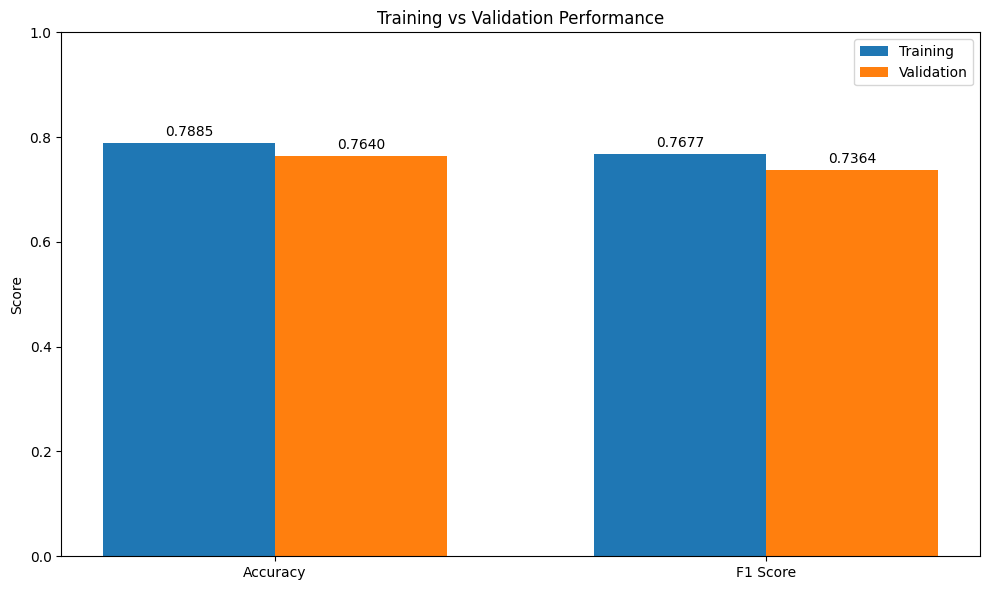

In [104]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_final)
train_accuracy = accuracy_score(y_train_final, y_pred_train)
train_f1 = f1_score(y_train_final, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_final)
val_accuracy = accuracy_score(y_val_final, y_pred_val)
val_f1 = f1_score(y_val_final, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Funzione per aggiungere valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [105]:
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print(f"Validation accuracy: {accuracy_score(y_val_final, y_pred_val)}")
print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_val, target_names=target_names))

Validation accuracy: 0.7640164713335446

Classification Report:
              precision    recall  f1-score   support

   tvEpisode       0.74      0.94      0.82       922
       movie       0.81      0.87      0.84      1118
    tvSeries       0.64      0.25      0.36       270
tvMiniSeries       0.00      0.00      0.00        28
       short       0.84      0.85      0.84       470
     tvMovie       0.47      0.20      0.28       171
   tvSpecial       0.24      0.12      0.16        34
       video       0.65      0.49      0.56       144

    accuracy                           0.76      3157
   macro avg       0.55      0.46      0.48      3157
weighted avg       0.74      0.76      0.74      3157



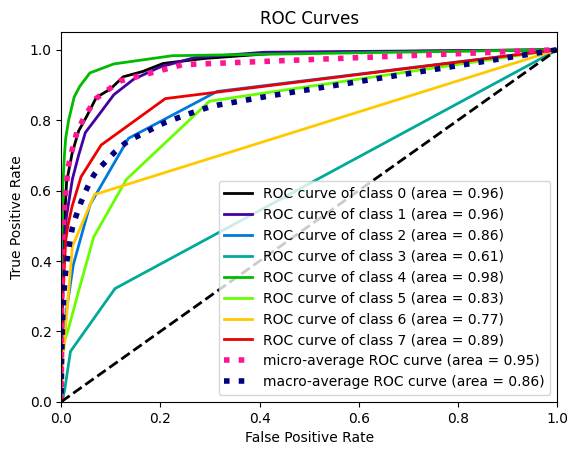

In [106]:
# Predizione probabilità sul validation set
y_val_pred_proba = clf.predict_proba(X_val_final)

# Plot della curva ROC (assumendo che plot_roc sia definita)
plot_roc(y_val_final, y_val_pred_proba)
plt.show()

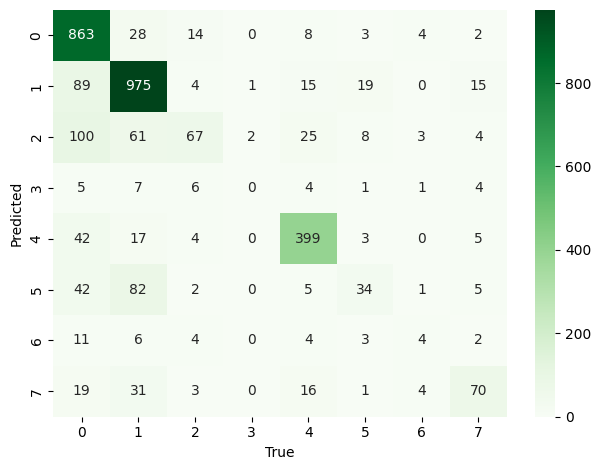

In [107]:
classes_unique = np.unique(y_val_final)
cm = confusion_matrix(y_val_final, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Concatenation of train & validation before testing on the test set

In [108]:
# Addestra il modello finale con i migliori parametri trovati
final_model = KNeighborsClassifier(weights = 'uniform', n_neighbors= 12, metric = 'cityblock')
final_model.fit(X_train_temp, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=12)

### Testing on the test set

In [109]:
y_test_pred = clf.predict(X_test_temp)

Performance sul Training set:
Accuracy: 0.7885
F1 Score: 0.7677

Performance sul Test set:
Accuracy: 0.7606
F1 Score: 0.7334


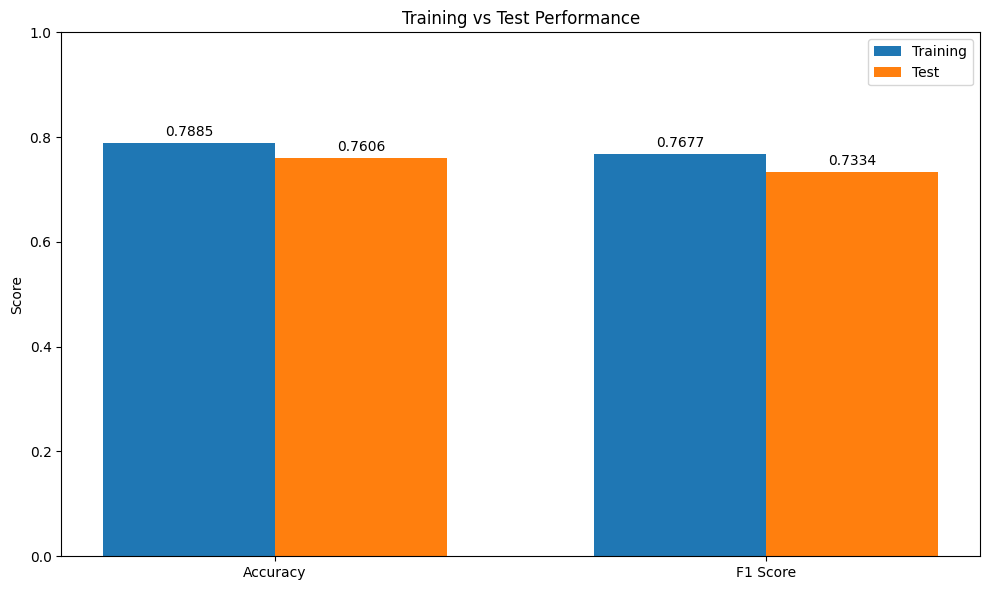

In [110]:
# Valutazione sul training set
y_pred_train = clf.predict(X_train_final)
train_accuracy = accuracy_score(y_train_final, y_pred_train)
train_f1 = f1_score(y_train_final, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = y_test_pred  # o direttamente clf.predict(X_test_temp) se vuoi
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Funzione per aggiungere valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [111]:
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

Test accuracy: 0.7605794891345787

Classification Report:
              precision    recall  f1-score   support

   tvEpisode       0.76      0.93      0.83      1596
       movie       0.81      0.87      0.84      1848
    tvSeries       0.61      0.24      0.34       437
tvMiniSeries       0.33      0.03      0.05        68
       short       0.79      0.85      0.82       728
     tvMovie       0.46      0.21      0.29       288
   tvSpecial       0.30      0.31      0.31        42
       video       0.59      0.44      0.50       239

    accuracy                           0.76      5246
   macro avg       0.58      0.48      0.50      5246
weighted avg       0.74      0.76      0.73      5246



In [112]:
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1477   45   22    0   31   10    6    5]
 [ 128 1609    7    0   23   40    2   39]
 [ 172   87  104    2   49   10    8    5]
 [  17   22   16    2    8    2    1    0]
 [  52   28   13    0  621    2    2   10]
 [  72  118    3    0   19   60    5   11]
 [  14    8    3    0    0    1   13    3]
 [  24   59    3    2   35    6    6  104]]
